In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

# 数据导入

In [3]:
import os

In [4]:
base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
transform = transforms.Compose([
    # 统一缩放到96 * 96
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    # 正则化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_ds = torchvision.datasets.ImageFolder(test_dir, transform=transform)

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

# 加载预训练好的模型

In [7]:
model = torchvision.models.vgg16(pretrained=True)

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
model.features.parameters()

<generator object Module.parameters at 0x000001784AC1FAC0>

# 修改参数

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
# 修改原网络中的输出层的结构. 
model.classifier[-1].out_features = 4

In [12]:
# 拷到gpu上
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 配置网络和训练网络

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# 加入学习率

In [14]:
from torch.optim import lr_scheduler

In [15]:
# 学习率衰减
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
def fit(epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0
    
    # 因为bn和dropout需要手动指定训练模式和推理模式
    model.train()
    for x, y in train_loader:
        # 把数据放到GPU上去. 
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    step_lr_scheduler.step() # 加入学习率
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
        
    # 测试过程
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / test_total

    print('epoch: ', epoch,
         'loss: ', round(epoch_loss, 3),
         'accuracy: ', round(epoch_acc, 3),
         'test_loss: ', round(test_epoch_loss, 3),
          
         'test_accuracy: ', round(test_epoch_acc, 3))
    return epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc

In [17]:
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

epoch:  0 loss:  0.067 accuracy:  0.785 test_loss:  0.02 test_accuracy:  0.924
epoch:  1 loss:  0.023 accuracy:  0.926 test_loss:  0.037 test_accuracy:  0.916
epoch:  2 loss:  0.01 accuracy:  0.958 test_loss:  0.019 test_accuracy:  0.964
epoch:  3 loss:  0.011 accuracy:  0.959 test_loss:  0.034 test_accuracy:  0.942
epoch:  4 loss:  0.007 accuracy:  0.974 test_loss:  0.039 test_accuracy:  0.916
epoch:  5 loss:  0.01 accuracy:  0.973 test_loss:  0.022 test_accuracy:  0.973
epoch:  6 loss:  0.009 accuracy:  0.973 test_loss:  0.058 test_accuracy:  0.929
epoch:  7 loss:  0.008 accuracy:  0.975 test_loss:  0.041 test_accuracy:  0.951
epoch:  8 loss:  0.001 accuracy:  0.993 test_loss:  0.037 test_accuracy:  0.951
epoch:  9 loss:  0.0 accuracy:  0.997 test_loss:  0.034 test_accuracy:  0.951


# 画图

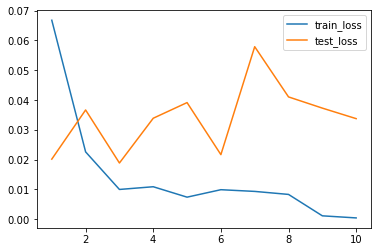

In [18]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

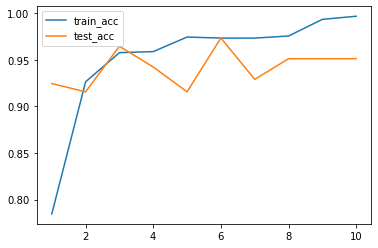

In [19]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 数据增强

transforms.RandomCrop    # 随机位置的裁剪 , CenterCrop 中间位置裁剪
transforms.RandomRotation # 随机旋转
transforms.RandomHorizontalFlip() # 水平翻转
transforms.RandomVerticalFlip() # 垂直翻转
transforms.ColorJitter(brightness) # 亮度
transforms.ColorJitter(contrast) # 对比度
transforms.ColorJitter(saturation) # 饱和度
transforms.ColorJitter(hue)
transforms.RandomGrayscale() # 随机灰度化.

In [21]:
# 数据增强只会加在训练数据上. 
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(192), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(0.4),
#     transforms.ColorJitter(brightness=0.5),
#     transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    # 正则化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [22]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # 正则化
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [23]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
test_ds = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

In [24]:
# 加载预训练好的模型
model = torchvision.models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# 修改原网络中的输出层的结构. 
model.classifier[-1].out_features = 4

# 拷到gpu上
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

from torch.optim import lr_scheduler

# 学习率衰减
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def fit(epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0
    
    # 因为bn和dropout需要手动指定训练模式和推理模式
    model.train()
    for x, y in train_loader:
        # 把数据放到GPU上去. 
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    step_lr_scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
        
    # 测试过程
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / test_total

    print('epoch: ', epoch,
         'loss: ', round(epoch_loss, 3),
         'accuracy: ', round(epoch_acc, 3),
         'test_loss: ', round(test_epoch_loss, 3),
         'test_accuracy: ', round(test_epoch_acc, 3))
    return epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc
    

In [25]:
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

epoch:  0 loss:  0.052 accuracy:  0.686 test_loss:  0.014 test_accuracy:  0.911
epoch:  1 loss:  0.017 accuracy:  0.884 test_loss:  0.014 test_accuracy:  0.898
epoch:  2 loss:  0.016 accuracy:  0.904 test_loss:  0.012 test_accuracy:  0.933
epoch:  3 loss:  0.008 accuracy:  0.945 test_loss:  0.013 test_accuracy:  0.942
epoch:  4 loss:  0.008 accuracy:  0.949 test_loss:  0.008 test_accuracy:  0.947
epoch:  5 loss:  0.008 accuracy:  0.948 test_loss:  0.016 test_accuracy:  0.916
epoch:  6 loss:  0.008 accuracy:  0.95 test_loss:  0.011 test_accuracy:  0.942
epoch:  7 loss:  0.008 accuracy:  0.962 test_loss:  0.01 test_accuracy:  0.942
epoch:  8 loss:  0.004 accuracy:  0.97 test_loss:  0.009 test_accuracy:  0.951
epoch:  9 loss:  0.004 accuracy:  0.975 test_loss:  0.009 test_accuracy:  0.96


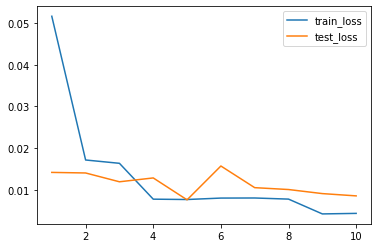

In [26]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

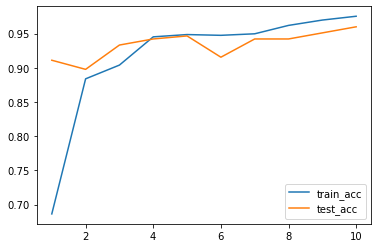

In [27]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()